In [45]:
import pandas as pd
from keras import Sequential
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scikeras.wrappers import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [3]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique()) #is this flip-flop the source of a problem? Don't think so

Unique values in label: [0 1]
Unique values in label: [1 0]


In [4]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [5]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [6]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y
print(X_train.shape)

(488524, 279)


In [ ]:
# 6️⃣ Train 1D CNN model
cnn_model = Sequential()
cnn_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(279, 1)))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.GlobalAveragePooling1D())
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

#my_model = KerasClassifier(build_fn=cnn_model)    
#my_model.fit(X_train,y_train)

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.5269 - loss: 65183900762112.0000
Epoch 2/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.6906 - loss: 476721920.0000
Epoch 3/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.7361 - loss: 30.1263
Epoch 4/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.7325 - loss: 111349608.0000
Epoch 5/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8270 - loss: 1790964352.0000
Epoch 6/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8529 - loss: 6217072640.0000
Epoch 7/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.8978 - loss: 1751410688.0000
Epoch 8/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9147 - loss: 2353415936.0000
Epoch 9/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9229 - loss: 1153442304.0000
Epoch 10/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9295 - loss: 7791153664.0000


C:\Users\david\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15267/15267 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9331 - loss: 0.2792


,model,None
,build_fn,"<Sequential n...3, built=True>"
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,1
,callbacks,None


In [50]:
# 7️⃣ Evaluate model
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3817/3817 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9315 - loss: 0.1756
Test Loss: 0.1747
Test Accuracy: 0.9306


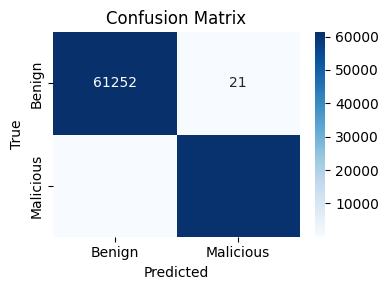

In [ ]:
# 8️⃣ Visualize Confusion Matrix
#not implementing this for CNN right now
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# 9️⃣ Feature Importance
#currently this seems to take forever to run, so I will maybe return to this
#perm = PermutationImportance(my_model, random_state=1).fit(X_train,y_train)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

15267/15267 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 3

KeyboardInterrupt: 

In [51]:
# 🔟 Save 
cnn_model.save("report/cnn_session_model.keras")
print("\nModel saved in report/")


Model saved in report/
